<a href="https://colab.research.google.com/github/joaochenriques/IST---Marine-Currents-and-Tidal-Energy/blob/main/Tidal_Stream/DiskActuator/ChannelFlows_PowerConversionLimits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
from scipy.optimize import root_scalar, minimize_scalar
import subprocess
import pathlib

def cmdcall( cmd, verbose = False ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import matplotlib.pyplot as mpl
import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

mpl.rcParams["figure.figsize"] = (12.5,3)

<img src="https://raw.githubusercontent.com/joaochenriques/IST_MCTE/main/ChannelFlows/DiskActuator/Figures/sub_domains.svg" width="500px" style="display:inline">

In [2]:
gr = 9.8

B   = 0.2
h1  = 20
Fr1 = 0.2

u1 = Fr1 * np.sqrt( gr * h1 )
u1

np.float64(2.8000000000000003)

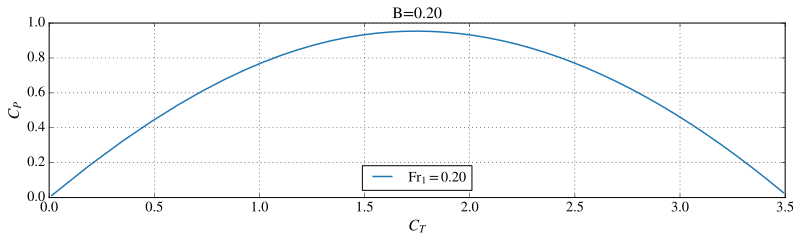

In [17]:
C_T_lst = []
C_P_lst = []

for alpha in np.linspace( 1.001, 3, 100 ):

    u4b = alpha * u1

    E1 = h1 + u1**2 / ( 2 * gr )
    h4 = E1 - u4b**2 / ( 2 * gr )

    kc = u1**2 * h1 + 0.5 * gr * ( h1**2 - h4**2 )
    kb = 0.5 * B * h1

    q = u1 * h1
    k1 = q - h4 * u4b

    u4t = ( k1 + np.sqrt( k1**2 + 4*kb*( u4b*( q + kb*u4b) - kc ) ) ) / ( 2 * kb )
    h4b = ( q - h4 * u4t ) / ( u4b - u4t )
    h4t = h4 - h4b

    u2t = u4t * h4t / ( h1 * B )

    C_T = ( u4b**2 - u4t**2 ) / u1**2
    C_P = C_T * u2t / u1

    if C_P <= 0.0: break

    C_P_lst.append( C_P )
    C_T_lst.append( C_T )

mpl.title( "B=%.2f" % B )
mpl.plot( C_T_lst, C_P_lst, label="$\mathrm{Fr}_1=%.2f$" % Fr1 )
mpl.grid()
mpl.legend(loc="lower center");
mpl.xlabel( "$C_T$" )
mpl.ylabel( "$C_P$" )

mpl.savefig('ChannelFlowLimits_Ex.pdf', bbox_inches='tight', pad_inches=0.02);

## Find the optimal value as a function of the upstream conditons

(np.float64(1.7451953385958465),
 np.float64(0.9538535118514689),
 np.float64(3.8141423560261023))

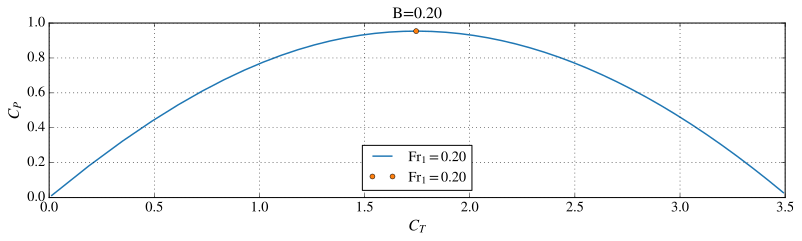

In [15]:
def local_CT_and_CP( u4b, u1, h1, B ):

    E1 = h1 + u1**2 / ( 2 * gr )
    h4 = E1 - u4b**2 / ( 2 * gr )

    kc = u1**2 * h1 + 0.5 * gr * ( h1**2 - h4**2 )
    kb = 0.5 * B * h1

    q = u1 * h1
    k1 = q - h4 * u4b

    u4t = ( k1 + np.sqrt( k1**2 + 4*kb*( u4b*( q + kb*u4b) - kc ) ) ) / ( 2 * kb )
    h4b = ( q - h4 * u4t ) / ( u4b - u4t )
    h4t = h4 - h4b

    u2t = u4t * h4t / ( h1 * B )

    C_T = ( u4b**2 - u4t**2 ) / u1**2
    C_P = C_T * u2t / u1

    return C_T, C_P


def find_minus_CP( u4b, u1, h1, B ):
    # function created to discard the C_T when calling "local_CT_and_CP"
    C_T, C_P = local_CT_and_CP( u4b, u1, h1, B )

    return -C_P # Minus C_P to allow minimization


res = minimize_scalar( find_minus_CP, args=(u1, h1, B), bounds=[u1, 2*u1],
                    method='bounded',
                    options={ 'xatol': 1e-08, 'maxiter': 500, 'disp': 1 } )
u4b = res.x # optimal value

C_T, C_P = local_CT_and_CP( u4b, u1, h1, B )


mpl.title( "B=%.2f" % B )
mpl.plot( C_T_lst, C_P_lst, label="$\mathrm{Fr}_1=%.2f$" % Fr1 )
mpl.plot( C_T, C_P, 'o', label="$\mathrm{Fr}_1=%.2f$" % Fr1 )
mpl.grid()
mpl.legend(loc="lower center");
mpl.xlabel( "$C_T$" )
mpl.ylabel( "$C_P$" )

mpl.savefig('ChannelFlowLimits_Ex.pdf', bbox_inches='tight', pad_inches=0.02);

C_T, C_P, u4b